In [818]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

from copy import deepcopy

In [950]:

class Host:
    def __init__(self):
        self.n_nodes = 6
        
        self.network = nx.binomial_graph(directed=True, n=self.n_nodes,p=0.5)
      
        for node in self.network.nodes:
            self.network.nodes[node]['active'] = 0.5


        for u,v,e in self.network.edges(data=True):
            e['weight'] = np.random.uniform(-1,1)

        self.network.remove_edges_from([(0,n_nodes-1),(n_nodes-1,0)])
        
    
    def update(self):
        network_copy = deepcopy(self.network)

        for node in self.network.nodes:
            dP = 0
            for n in self.network.predecessors(n=node):
                weight = nx.get_edge_attributes(self.network,'weight')[(n,node)] 
                if weight > 0:
                    dP += (1-self.network.node[node]['active'])*weight*self.network.node[n]['active']
                elif weight < 0:
                    dP += self.network.node[node]['active']*weight*self.network.node[n]['active']
            
            if np.isnan(dP):
                print('NAN!')
                print(nx.get_edge_attributes(self.network,'weight'))
                print(nx.get_node_attributes(self.network,'active'))
            
            if network_copy.node[node]['active'] + dP > 1:
                network_copy.node[node]['active'] = 1
            elif network_copy.node[node]['active'] + dP < 0:
                network_copy.node[node]['active'] = 0
            else:
                network_copy.node[node]['active'] += dP
            
            #network_copy.node[node]['active'] = min(1, network_copy.node[node]['active'] + dP) 

        self.network = network_copy
    
    
    def fitness(self):
        """
        formula for fitness
        """
        pass
        
    def mutate(self):
        pass
    
    
    def visualize(self):
        edges,weights = zip(*nx.get_edge_attributes(self.network,'weight').items())

        activating = [e for e,w in nx.get_edge_attributes(self.network,'weight').items() if w > 0]
        positive_weights = [round(w,1) for e,w in nx.get_edge_attributes(self.network,'weight').items() if w > 0]

        deactivating = [e for e,w in nx.get_edge_attributes(self.network,'weight').items() if w < 0]
        negative_weights = [round(w,1) for e,w in nx.get_edge_attributes(self.network,'weight').items() if w < 0]

        active_ratios = list(nx.get_node_attributes(self.network,'active').values())

        pos = nx.shell_layout(self.network)

        graph_nodes = nx.draw_networkx_nodes(self.network, node_size=300, pos=pos, alpha=1, 
                               node_color= [a for a in active_ratios],
                                            cmap='Greens', vmin=0, vmax=1.5)  

        graph_act_edges =nx.draw_networkx_edges(self.network, edgelist=activating,
                               pos=pos, width=[5*abs(w)+1 for w in positive_weights], arrowsize=20, edge_color= '#0055FF',
                                alpha=1)

        graph_deact_edges = nx.draw_networkx_edges(self.network, edgelist=deactivating,
                               pos=pos, width=[5*abs(w)+1 for w in negative_weights], arrowsize=30, edge_color = '#FF0000',
                                alpha=0.6, arrowstyle=matplotlib.patches.ArrowStyle("|-|",widthA=0, widthB=0.3))
        
        if n_nodes == self.network.number_of_nodes():
            letters = ['D']+(self.n_nodes-2)*['S']+['E'] 
        else:
            n_added_signalers = self.network.number_of_nodes() - n_nodes
            letters = ['D']+(self.n_nodes-2)*['S']+['E'] + n_added_signalers*['S']
            
        labels = dict(zip(self.network.nodes,letters))

        nx.draw_networkx_labels(self.network, pos=pos, 
                               labels = labels)
        nx.draw_networkx_edge_labels(self.network, font_color='#0055FF', label_pos=0.3, pos=pos, edge_labels=dict(zip(activating,positive_weights)))
        nx.draw_networkx_edge_labels(self.network, font_color='#FF0000', label_pos = 0.3, pos=pos, edge_labels=dict(zip(deactivating,negative_weights)))
        
        graph_nodes.set_edgecolor('k')

        for e in graph_act_edges+graph_deact_edges:
            e.set_alpha(0.5)

        plt.show()
        
        
        
        
#         edges,weights = zip(*nx.get_edge_attributes(self.network,'weight').items())
        
#         letters = ['D']+(self.network.number_of_nodes()-2)*['S']+['E']
#         labels = dict(zip(self.network.nodes,letters))
        
#         nx.draw(self.network, node_size=1000,
#         with_labels=True, labels = labels,
#         cmap= plt.cm.viridis, edge_color=weights,
#        width=5) 
        
        
#         return np.exp(-self.network)

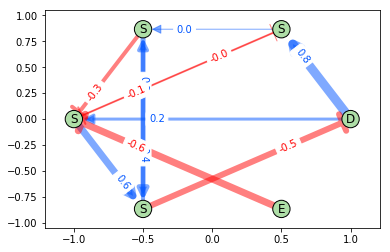

(0.8149397657840192,
 0.22583397984913556,
 0.04728553256151424,
 -0.07363687358914994,
 -0.2677129378582006,
 0.43892933650378385,
 -0.04143337916760603,
 0.5889204547907552,
 -0.528527852743311,
 0.3053907319179556,
 -0.6273660013585456)

In [750]:
n_nodes = 6
host_network = nx.binomial_graph(directed=True, n=n_nodes,p=0.5)

#### initialize


for node in host_network.nodes:
    host_network.nodes[node]['active'] = 0.5


for u,v,e in host_network.edges(data=True):
    e['weight'] = np.random.uniform(-1,1)

host_network.remove_edges_from([(0,n_nodes-1),(n_nodes-1,0)])




#### visualize

edges,weights = zip(*nx.get_edge_attributes(host_network,'weight').items())

activating = [e for e,w in nx.get_edge_attributes(host_network,'weight').items() if w > 0]
positive_weights = [round(w,1) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w > 0]

deactivating = [e for e,w in nx.get_edge_attributes(host_network,'weight').items() if w < 0]
negative_weights = [round(w,1) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w < 0]

active_ratios = list(nx.get_node_attributes(host_network,'active').values())

pos = nx.shell_layout(host_network)

graph_nodes = nx.draw_networkx_nodes(host_network, node_size=300, pos=pos, alpha=1, 
                       node_color= [a for a in active_ratios],
                                    cmap='Greens', vmin=0, vmax=1.5)  

graph_act_edges =nx.draw_networkx_edges(host_network, edgelist=activating,
                       pos=pos, width=[10*abs(w)+1 for w in positive_weights], arrowsize=20, edge_color= '#0055FF',
                        #edge_cmap= plt.cm.Blues, vmax=1, edge_color=positive_weights,
                        alpha=1)

graph_deact_edges = nx.draw_networkx_edges(host_network, edgelist=deactivating,
                       pos=pos, width=[10*abs(w)+1 for w in negative_weights], arrowsize=30, edge_color = '#FF0000',
                        #edge_cmap= plt.cm.Reds, edge_color=negative_weights,
                        alpha=0.6, arrowstyle=matplotlib.patches.ArrowStyle("|-|",widthA=0, widthB=0.3))

letters = ['D']+(host_network.number_of_nodes()-2)*['S']+['E']
labels = dict(zip(host_network.nodes,letters))

nx.draw_networkx_labels(host_network, pos=pos, 
                       labels = labels)
nx.draw_networkx_edge_labels(host_network, font_color='#0055FF', label_pos=0.3, pos=pos, edge_labels=dict(zip(activating,positive_weights)))
nx.draw_networkx_edge_labels(host_network, font_color='#FF0000', label_pos = 0.3, pos=pos, edge_labels=dict(zip(deactivating,negative_weights)))


#ax = plt.gca() # to get the current axis

graph_nodes.set_edgecolor('k')

for e in graph_act_edges+graph_deact_edges:
    e.set_alpha(0.5)

plt.show()

weights

In [728]:
#nx.get_edge_attributes(host_network,'weight')
list(nx.get_node_attributes(host_network,'active').values())
#[node for node in host_network.nodes]
#list(host_network.nodes)[0]

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

In [171]:
host_network.remove_edges_from(n_nodes-1)

TypeError: 'int' object is not iterable

In [165]:
list(host_network.neighbors(4))

[]

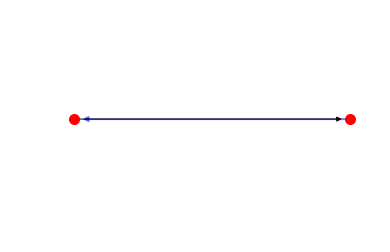

In [331]:
G = nx.DiGraph()
G.add_nodes_from([0,1])
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, node_color = 'r', node_size = 100, alpha = 1)
nx.draw_networkx_edges(G, pos, edgelist = [(0,1)], width = 2, alpha = 0.5, edge_color='b')
nx.draw_networkx_edges(G, pos, edgelist= [(1,0)], width = 1, alpha = 1)
plt.axis('off')
plt.show() 

In [352]:
#list(host_network.edges.data())

activating = [(u,v) for u,v,d in host_network.edges.data() if d['weight'] > 0]
deactivating =[(u,v) for u,v,d in host_network.edges.data() if d['weight'] < 0]

[(1, 3), (2, 4), (3, 0), (4, 3)]

In [390]:
activating = [(e,w) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w > 0]
deactivating = [(e,w) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w < 0]

positive_weights = 
negative_weights = 

In [406]:
np.array([(e,w) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w > 0])

array([[(2, 0), 0.5],
       [(2, 3), 0.5],
       [(4, 2), 0.5],
       [(4, 3), 0.5]], dtype=object)

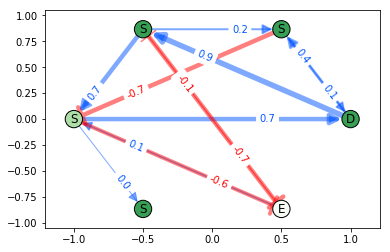

{0: 0.9999999999999999,
 1: 1.0,
 2: 1.0,
 3: 0.4988254411181427,
 4: 0.9991518532844252,
 5: 0.0}

In [964]:
net = Host()
for _ in range(1000):
    net.update()

net.visualize()

nx.get_node_attributes(net.network,'active')

In [940]:
network_copy = deepcopy(self.network)

for node in self.network.nodes:
    dP = 0
    for n in self.network.predecessors(n=node):
        weight = nx.get_edge_attributes(self.network,'weight')[(n,node)] 
        if weight > 0:
            dP += (1-self.network.node[node]['active'])*weight*self.network.node[n]['active']
        else:
            dP += self.network.node[node]['active']*weight*self.network.node[n]['active']
    
    network_copy.node[node]['active'] += dP

self.network = network_copy
    #self.network.node[node]['active'] += dP
    
    
    #print(n)
    #print(nx.get_edge_attributes(self.network,'weight')[(n,5)])
    
#self.network.s

NameError: name 'self' is not defined

In [819]:
#net.network.get_edge_attribute('weight')
#net.network.predecessors(n=5)

#activating

for node in net.network.nodes:
    print(node)

0
1
2
3
4
5
